In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')
import pickle

import tarp
import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import datasets
from sbi.utils import BoxUniform
from sbi_stream import infer_utils
from sbi_stream.npe import NPE

%matplotlib inline
plt.style.use('/global/homes/t/tvnguyen/default.mplstyle')

/global/homes/t/tvnguyen/.conda/envs/torch-py11/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
run_dir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/tarp'
run_files = [
    'uncertainty-nsf10/spline-6d-present.pkl',
    'uncertainty-nsf10/spline-2d-future.pkl',
    'uncertainty-nsf10/spline-6d-future.pkl',
    'uncertainty-nsf10/spline-6+2d-future.pkl',

]
run_labels = [
    'Present 6D',
    'Future 2D',
    'Future 6D',
    'Future 6+2D',
]


all_ecps = []
all_alphas = []
for run_file, run_label in zip(run_files, run_labels):
    save_file = os.path.join(run_dir, run_file)
    if not os.path.exists(save_file):
        print(f"File {save_file} does not exist. Skipping.")
        continue

    print(f"Loading {run_label} data from {save_file}")

    # Load the data
    with open(save_file, 'rb') as f:
        data = pickle.load(f)
    ecp = data['ecp']
    alpha = data['alpha']
    all_ecps.append(ecp)
    all_alphas.append(alpha)

Loading Present 6D data from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/tarp/uncertainty-nsf10/spline-6d-present-2.pkl
Loading Future 2D data from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/tarp/uncertainty-nsf10/spline-2d-future.pkl
Loading Future 6D data from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/tarp/uncertainty-nsf10/spline-6d-future.pkl
Loading Future 6+2D data from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/tarp/uncertainty-nsf10/spline-6+2d-future.pkl


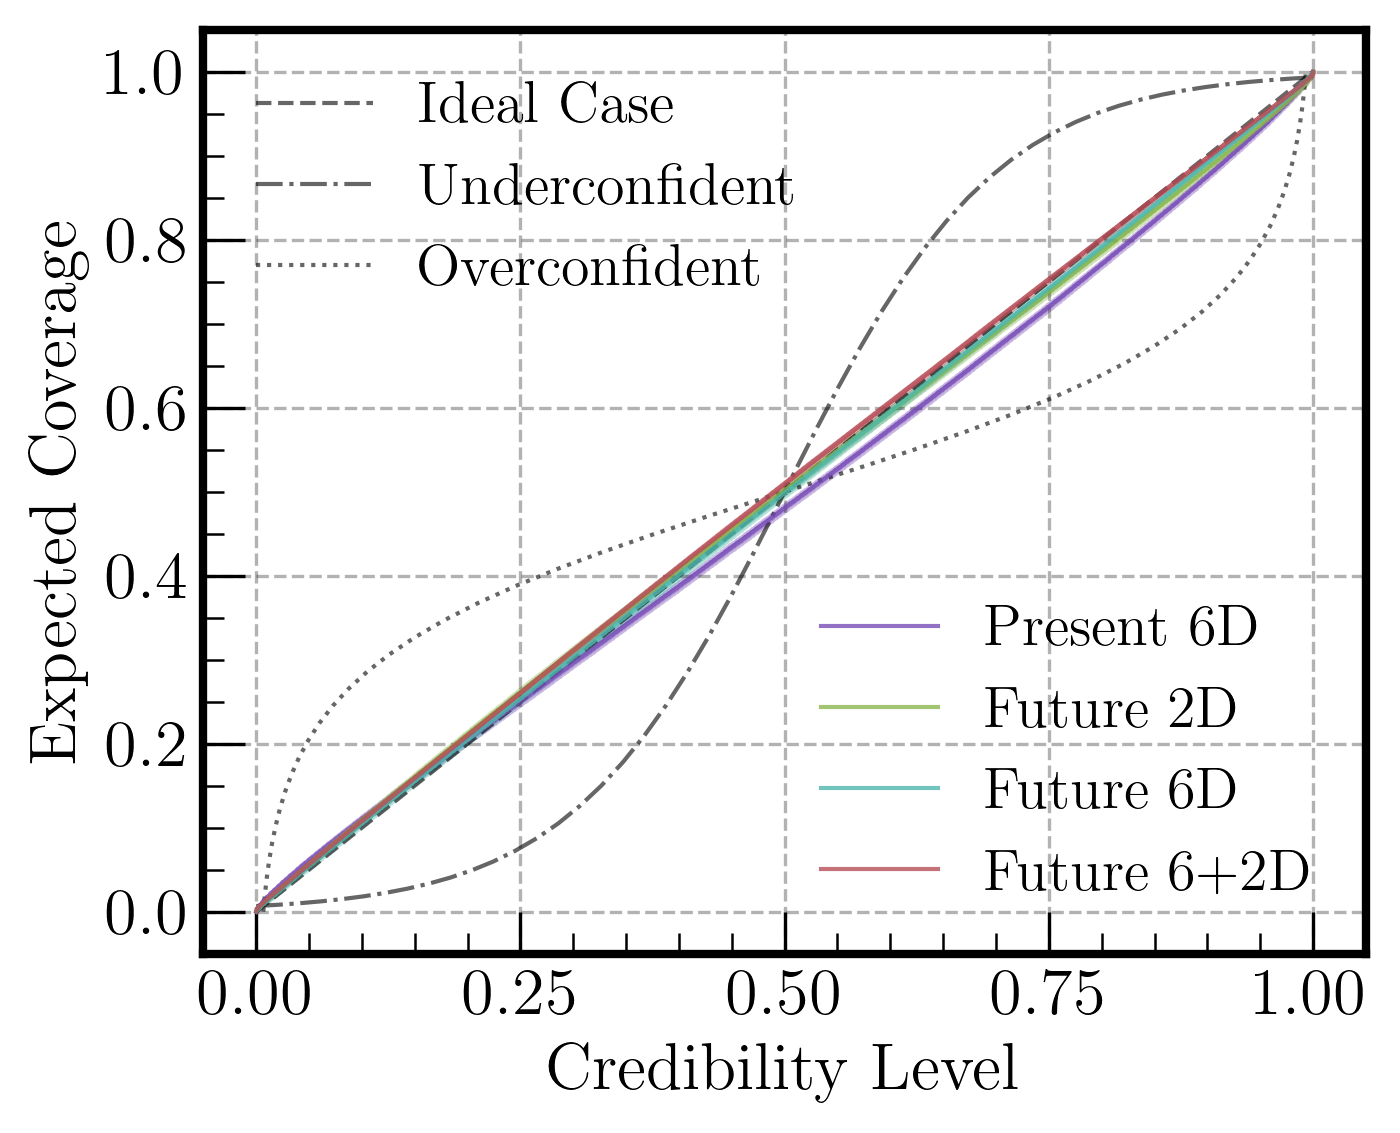

In [3]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

# colors = [
#     "C0",
#     "#840020",
#     "orangered",
# ]
colors = [
    "#784db7",
    "#8cb74d",
    "#4db7ad",
    "#b74d57"
]
# Generate alpha values (credibility levels)
alpha = np.linspace(0.0, 1, 50)
ecp = 0.5 * np.tanh(5 * (alpha - 0.5)) + 0.5

# Plot the overconfident and underconfident curves
ax.plot([0, 1], [0, 1], ls='--', alpha=0.6, color='k', label="Ideal Case", lw=1)
ax.plot(
    alpha, ecp, color='k', label='Underconfident',
    lw=1, alpha=0.6, linestyle='-.')
ax.plot(
    ecp, alpha, color='k', label='Overconfident',
    lw=1, alpha=0.6, linestyle=':')


# Plot your original data curves
for i, (ecp_data, alpha_data, run_label) in enumerate(zip(all_ecps, all_alphas, run_labels)):
    # calculate the mean and 1-sigma of the ECP
    mean_ecp = np.mean(ecp_data, axis=0)
    std_ecp = np.std(ecp_data, axis=0)

    ax.plot(alpha_data, mean_ecp, color=colors[i], label=f'{run_label}', lw=1, alpha=0.8)
    ax.fill_between(
        alpha_data, mean_ecp - std_ecp, mean_ecp + std_ecp, lw=1,
        color=colors[i], alpha=0.4
    )

# First legend for ideal/overconfident/underconfident curves
handles, labels = ax.get_legend_handles_labels()
handles = handles[:3]  # Keep only the first three handles
labels = labels[:3]  # Keep only the first three labels
legend1 = ax.legend(
    handles, labels, loc='upper left', fontsize=14, frameon=False, ncol=1,)

# Second legend for the original data curves
handles, labels = ax.get_legend_handles_labels()
handles = handles[3:]  # Keep only the data curves
labels = labels[3:]  # Keep only the data curve labels
legend2 = ax.legend(
    handles, labels, loc='lower right', fontsize=14, frameon=False, ncol=1,
)
ax.add_artist(legend1)  # Add the first legend to the plot

ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

fig.savefig('figures/tarp_err.pdf', bbox_inches='tight', dpi=300)